In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import tensorflow as tf

from src.DataPreprocessor.data_preprocessor import DataPreprocessor, Mode
from src.LearningKeras.net_architecture import cnn_150x150x5_3class
from src.LearningKeras.train import KerasTrainer
import h5py

from tqdm import trange

np.random.seed(1)
tf.set_random_seed(2)

In [2]:
from src.DataPreprocessor.DataIOBackend.gdal_backend import GdalBackend
from src.DataPreprocessor.data_visualiser import DataVisualiser

dataiobackend = GdalBackend()
data_preprocessor = DataPreprocessor(data_dir="data/Region 1 - Lopukangri/",
                              backend=dataiobackend,
                              filename_prefix="tibet",
                              mode=Mode.TRAIN,
                              seed=1)

In [3]:
model_generator = lambda: cnn_150x150x5_3class()
ensemble_size = 3
batch_size = 10

trainer = KerasTrainer(model_generator=model_generator,
                       ensemble_size=ensemble_size,
                       data_preprocessor=data_preprocessor,
                       batch_size=batch_size)

In [7]:
dataiobackend_muga_puruo = GdalBackend()
data_preprocessor_muga_puruo = DataPreprocessor(data_dir="data/Region 2 - Muga Puruo/",
                              backend=dataiobackend_muga_puruo,
                              filename_prefix="mpgr",
                              mode=Mode.TEST,
                              seed=1)

In [7]:
boxes, avg_fault_probs, avg_lookalike_probs, avg_non_fault_probs = trainer.apply_for_sliding_window_3class_batch(data_preprocessor_muga_puruo, stride=50, batch_size=20)

KeyboardInterrupt: 

In [9]:
with h5py.File('integration_tests/predicting_tmp_muga_puruo_3classes.h5', 'w') as hf:
    hf.create_dataset("dataset",  data=np.array(boxes))
with h5py.File('integration_tests/predicting_tmp2_muga_puruo_3classes.h5', 'w') as hf:
    hf.create_dataset("dataset",  data=np.array(avg_fault_probs))    

In [5]:
with h5py.File('integration_tests/predicting_tmp_muga_puruo_3classes.h5', 'r') as hf:
    boxes = hf['dataset'][:]
with h5py.File('integration_tests/predicting_tmp2_muga_puruo_3classes.h5', 'r') as hf:
    avg_fault_probs = hf['dataset'][:]

In [8]:
res = trainer.apply_for_sliding_window_heatmaps(boxes, avg_fault_probs, data_preprocessor_muga_puruo)

100%|██████████| 3969/3969 [00:00<00:00, 7839.57it/s]


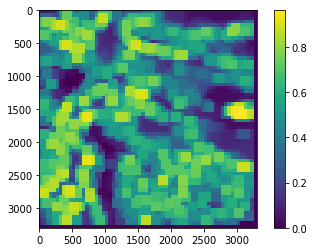

In [9]:
plt.imshow(np.array(res))
plt.colorbar()
plt.show()

### heatmaps

In [10]:
cmap = plt.get_cmap('jet')
rgba_img = cmap(res)
rgb_img = np.delete(rgba_img, 3, 2)

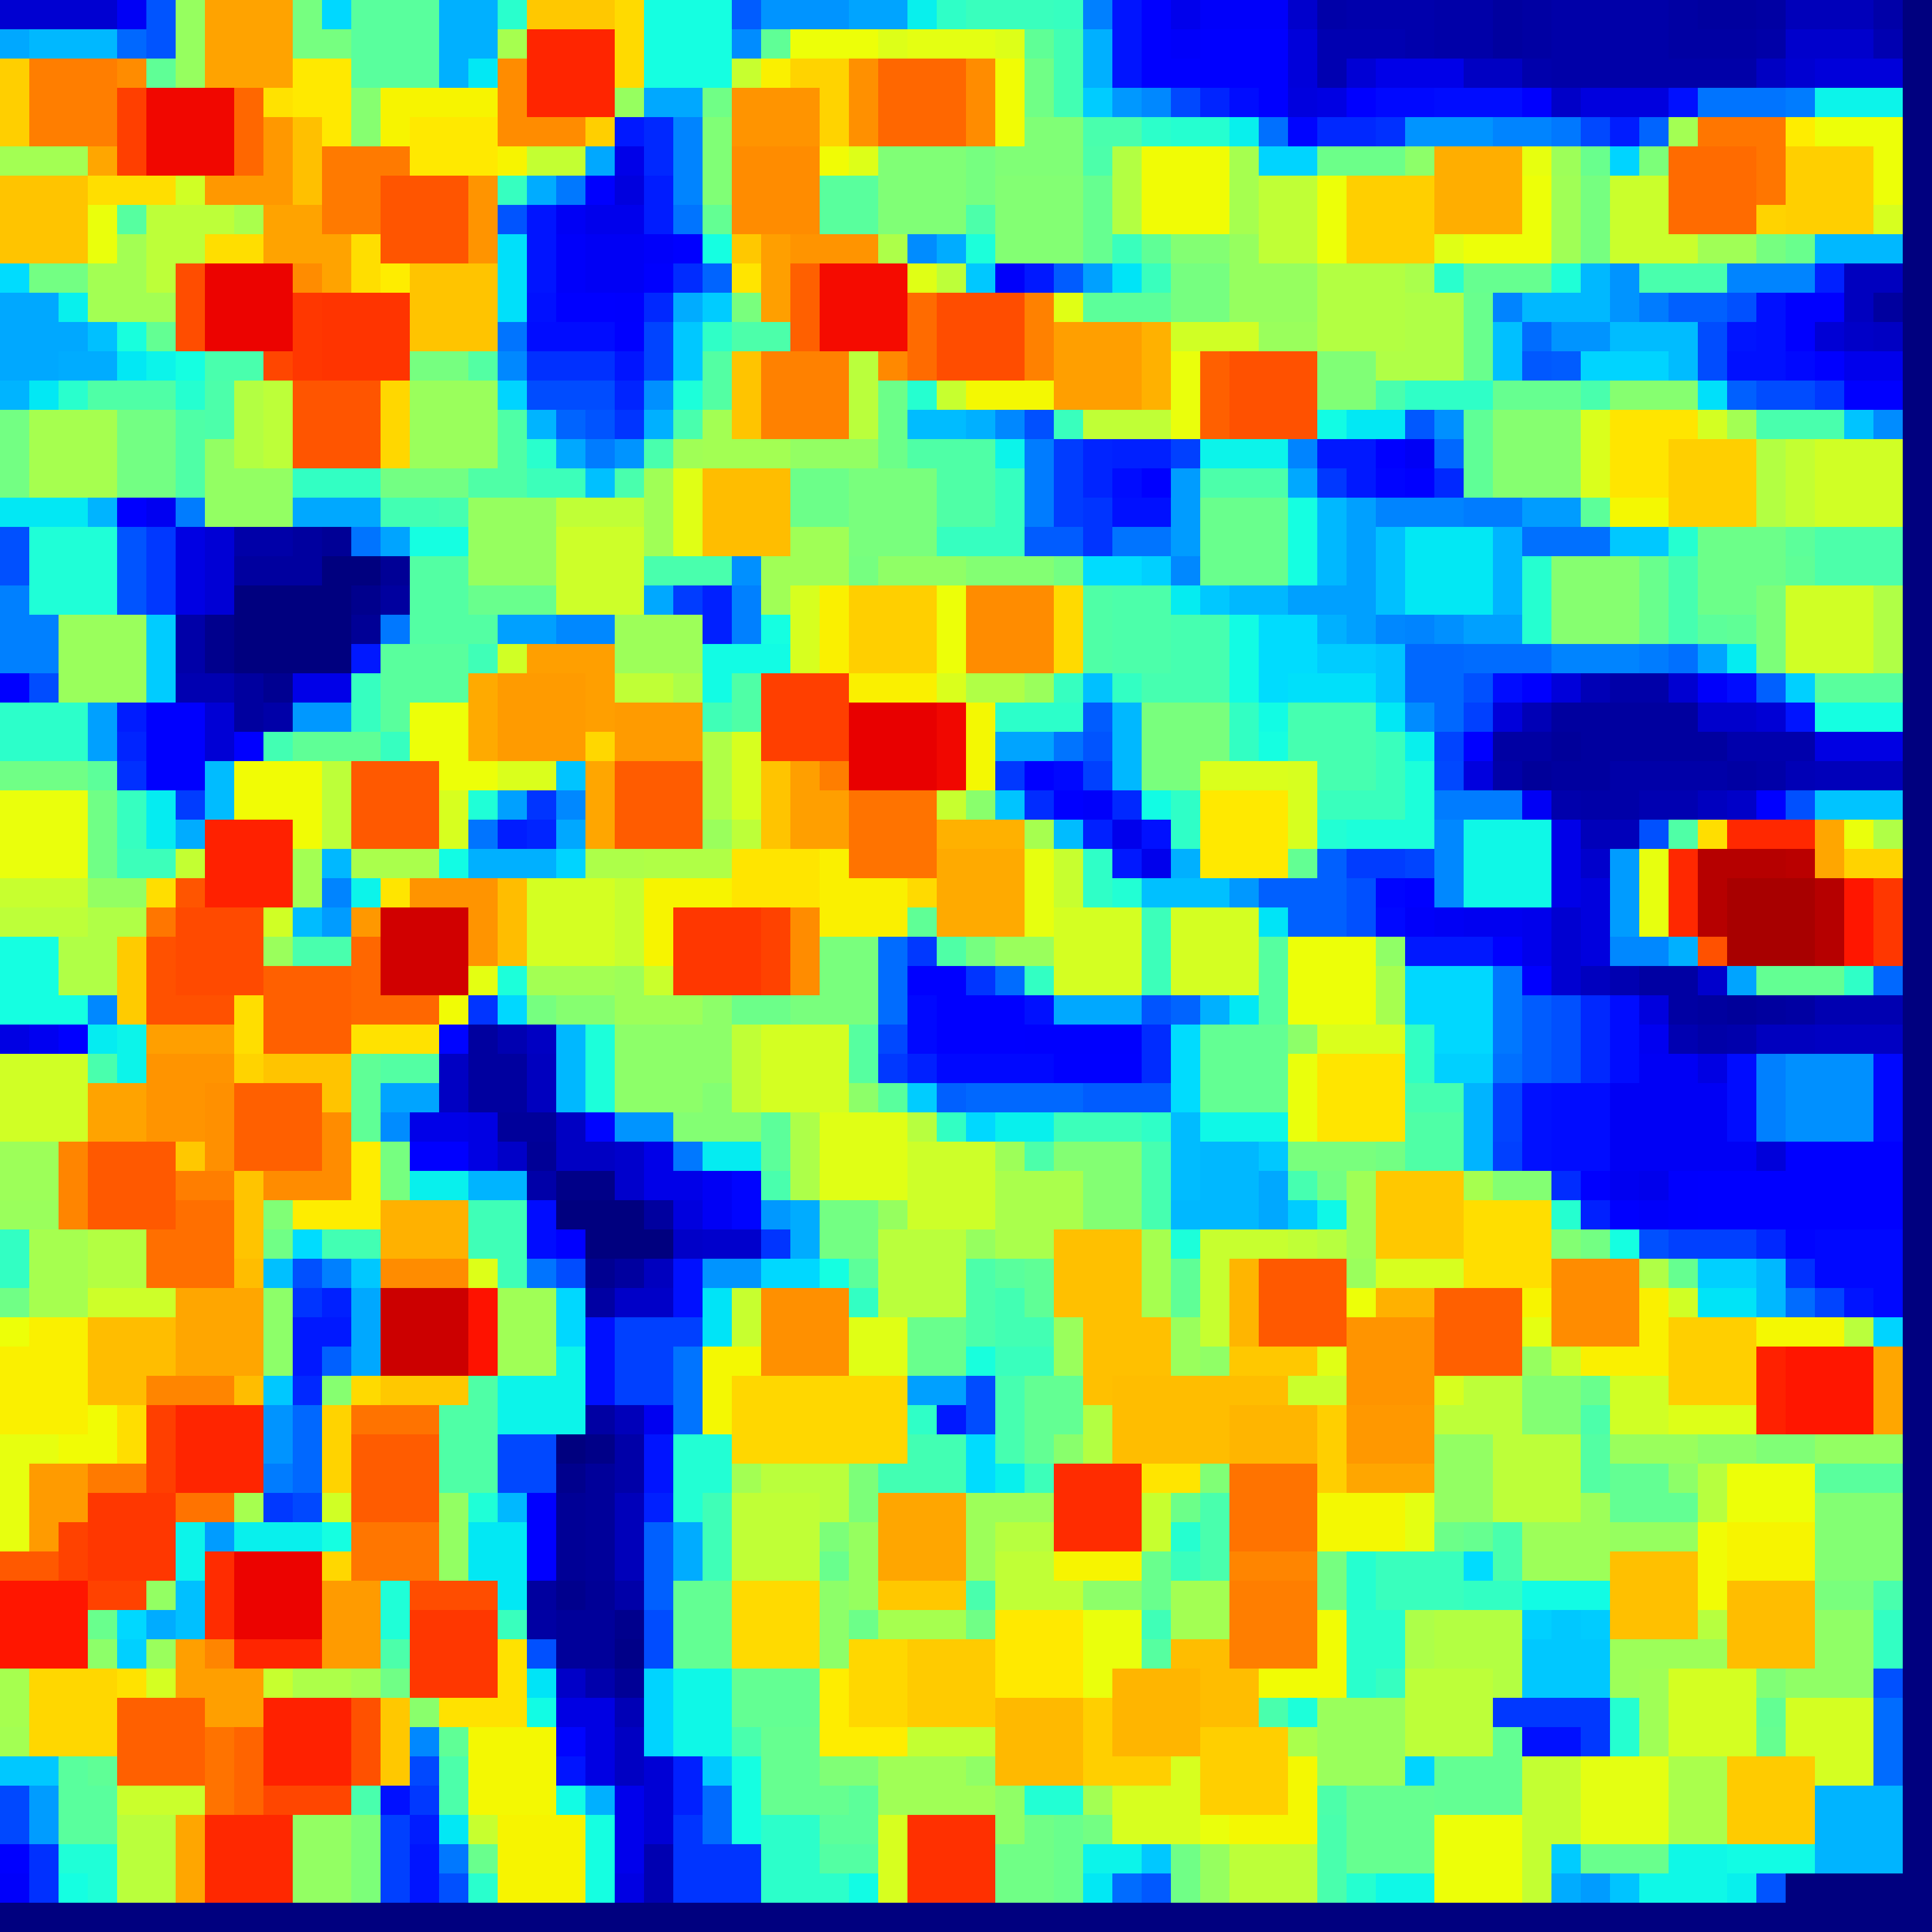

In [11]:
res_im=(rgba_img[:, :, :3] * 255).astype(np.uint8)
Image.fromarray(res_im)

In [16]:
# import gdal

In [14]:
#cmap = plt.get_cmap('jet')
#rgba_img_lookalikes = cmap(res_lookalikes)
#rgb_img_lookalikes = np.delete(rgba_img_lookalikes, 3, 2)
#rgb_img_lookalikes=(rgb_img_lookalikes[:, :, :3] * 255).astype(np.uint8)
dataiobackend_muga_puruo.write_image("heatmaps_muga_puruo_3class_heatmaps.tif", res_im)

In [18]:
# driver = dataiobackend_muga_puruo.gdal_options['driver']
# dst_ds = driver.Create("heatmaps_3_colours_muga_puruo.tif", xsize=res_im.shape[0], ysize=res_im.shape[1], 
#                        bands=3, eType=gdal.GDT_Byte)

# geotransform = dataiobackend_muga_puruo.gdal_options['geotransform']
# dst_ds.SetGeoTransform(geotransform)
# projection = dataiobackend_muga_puruo.gdal_options['projection']
# dst_ds.SetProjection(projection)
# #raster = image.astype(np.uint8)
# dst_ds.GetRasterBand(1).WriteArray(res_im[:, :, 0])
# dst_ds.GetRasterBand(2).WriteArray(res_im[:, :, 1])
# dst_ds.GetRasterBand(3).WriteArray(res_im[:, :, 2])
# dst_ds = None

In [ ]:
#res.save('sliding_window_heatmaps.tif')